In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA as sklearnPCA
import pandas as pd
import yfinance as yf 

import seaborn as sns

import sys
from scipy.stats import norm
import ezodf
import scipy.optimize as sco
import scipy

from sklearn.covariance import LedoitWolf
from datetime import datetime

from numpy import matlib as mb


/opt/anaconda3/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
def Optimize_Portfolio(data ,risk_free = 0, objective = 'Kelly'):
    

    
    
    if objective == 'Kelly':  
        #ret = (data).prod()**(1/len(data)) - 1 #cagr
        ret = (data-1).mean()
        #cov = data.cov().to_numpy()
        cov_fit = LedoitWolf().fit(data)
        cov = cov_fit.covariance_
        
        #need smaller step size
        num_assets = ret.shape[0]
        args = (ret, cov,risk_free)
        constraints = ({'type':'ineq', 'fun': lambda x: x},#all elements greater than one
                      {'type':'ineq', 'fun': lambda x: 1 - np.sum(x)}) # sum <= 1
                      #{'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  
        
        
        result = sco.minimize(kelly_objective, num_assets*[1./num_assets,], args=args, 
                                  method='SLSQP', constraints=constraints, tol = 0.0000000000000000000000001) 
        
    elif objective == 'Sharpe':
        ret = (data-1).mean() 
      
        cov_fit = LedoitWolf().fit(data)
        cov = cov_fit.covariance_
        
        num_assets = ret.shape[0]
        args = (ret, cov,risk_free)
        constraints = ({'type':'ineq', 'fun': lambda x: x},#all elements greater than one
                  #{'type':'ineq', 'fun': lambda x: 1 - np.sum(x)} # sum <= 1
                  {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  
        result = sco.minimize(sharpe_objective, num_assets*[1./num_assets,], args=args, 
                              method='SLSQP', constraints=constraints, tol = 0.0000000000000000000000001)
    
    elif objective == 'Max Div':
        num_assets = len(data.columns)
        #cov = data.cov().to_numpy()
        
        cov_fit = LedoitWolf().fit(data)
        cov = cov_fit.covariance_
        
        args = (cov)
        constraints = ({'type':'ineq', 'fun': lambda x: x},#all elements greater than one
                  #{'type':'ineq', 'fun': lambda x: 1 - np.sum(x)} # sum <= 1
                  {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}) 
        
        result = sco.minimize(calc_diversification_ratio, num_assets*[1./num_assets,], args=args, 
                              method='SLSQP', constraints=constraints, tol = 0.0000000000000000000000001)
        
    elif objective == "min var":
        num_assets = len(data.columns)
        
        
        cov_fit = LedoitWolf().fit(data)
        cov = cov_fit.covariance_
        
        args = (cov)
        constraints = ({'type':'ineq', 'fun': lambda x: x},#all elements greater than one
                  #{'type':'ineq', 'fun': lambda x: 1 - np.sum(x)} # sum <= 1
                  {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}) 
        
        result = sco.minimize(port_var, num_assets*[1./num_assets,], args=args, 
                              method='SLSQP', constraints=constraints, tol = 0.0000000000000000000000001)
    elif objective == "erc":
        num_assets = len(data.columns)
        #cov = data.cov().to_numpy()
        
        cov_fit = LedoitWolf().fit(data)
        cov = cov_fit.covariance_
        
        args = (cov)
        constraints = ({'type':'ineq', 'fun': lambda x: x},#all elements greater than one
                  #{'type':'ineq', 'fun': lambda x: 1 - np.sum(x)} # sum <= 1
                  {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}) 
        
        result = sco.minimize(erc, num_assets*[1./num_assets,], args=args, 
                              method='SLSQP', constraints=constraints, tol = 0.0000000000000000000000001)
        
        
        
    
    return (result)

def kelly_objective(weights,ret, cov, risk_free = 0):
    
    #kelly_ret = port_ret(weights, ret)
    kelly_ret = port_ret(weights, ret) - port_var(weights, cov)/2
    
    obj = -(kelly_ret)
    
    return(obj)

def sharpe_objective(weights,ret, cov, risk_free = 0):
    ret = port_ret(weights, ret)
    std = port_var(weights, cov)**(1/2)
    
    obj = - (ret/std)
    return(obj)


def port_var(weights, cov):
    var = weights.dot(cov).dot(weights)
    return(var)

def port_ret(weights, ret, risk_free = 0):
    #needs to be array
    ret = ret - risk_free
    port_ret = weights.dot(ret)
    return(port_ret)

def risk_parity(data):
    vol = np.log((data)).std()

    sum_vol = 0
    for i in range(len(vol)):
        sum_vol =sum_vol + (1/vol[i])
    
    weight = []
    for i in range(len(vol)):
        w = (1/vol[i])/(sum_vol)
        weight.append(w)
   
    weight = [round(num, 2) for num in weight]
    return(weight)

def cdar_parity(data):
    alpha= 0.05
    cumret = (data+1).cumprod()
    Roll_Max = cumret.cummax()
    Daily_Drawdown = cumret/Roll_Max - 1.0
    cdar_dd = Daily_Drawdown[Daily_Drawdown<Daily_Drawdown.quantile(0.05)].mean()



    sum_vol = 0
    for i in range(len(cdar_dd)):
        sum_vol =sum_vol + (1/cdar_dd[i])
    
    weight = []
    for i in range(len(cdar_dd)):
        w = (1/cdar_dd[i])/(sum_vol)
        weight.append(w)
   
    weight = [round(num, 2) for num in weight]
    return(weight)


def calc_diversification_ratio(weights, cov):
    # average weighted vol
    w_vol = np.dot(np.sqrt(np.diag(cov)), weights.T)
    # portfolio vol
    port_vol = np.sqrt(port_var(weights, cov))
    
    diversification_ratio = w_vol/port_vol
    # return negative for minimization problem (maximize = minimize -)
    return -diversification_ratio

def erc(weights, cov):
        # these are non normalized risk contributions, i.e. not regularized
        # by total risk, seems to help numerically
        risk_contributions = np.dot(weights, cov) * weights
        a = np.reshape(risk_contributions, (len(risk_contributions), 1))
        # broadcasts so you get pairwise differences in risk contributions
        risk_diffs = a - a.transpose()
        sum_risk_diffs_squared = np.sum(np.square(np.ravel(risk_diffs)))
        # https://stackoverflow.com/a/36685019/1451311
        return sum_risk_diffs_squared #/ scale_factorcov


In [3]:
def strategy_evaluation(result, data_names, freq = 'D'):

    
    port = pd.DataFrame(result)
    port_ret = calc_port_ret(port)
    
    metrics = pd.DataFrame([])
    
    if freq == 'D':
    
        for i in result.columns:
            metrics = pd.concat([metrics, port_eval(result[i], freq = 'D').transpose()], 
                               axis = 0)
        metrics.index = data_names
        
    elif freq == 'M':
        for i in result.columns:
            metrics = pd.concat([metrics, port_eval(result[i], freq = 'M').transpose()], axis = 0)
        metrics.index = data_names
        
    th_props = [
  ('font-size', '11px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', 'Black'),
  ('background-color', '#f7f7f9')
  ]


    # Set CSS properties for td elements in dataframe
    td_props = [
      ('font-size', '11px'), ('text-align', 'center')
      ]

    # Set table styles
    styles = [
      dict(selector="th", props=th_props),
      dict(selector="td", props=td_props)
      ]

    cm_neg_good = sns.diverging_palette(150, 10, s=80, l=70, n=int(len(metrics.columns)), as_cmap=True)#sns.light_palette("green", as_cmap=True)
    cm_pos_good = sns.diverging_palette(10, 150, s=80, l=70, n=int(len(metrics.columns)), as_cmap=True)

    metrics = (metrics.style
      .background_gradient(axis = 0 ,subset = ['CAGR','Max DD', 'Sharpe','MAR','Sortino'],cmap=cm_pos_good)
      .background_gradient(axis = 0 ,subset = ['Volatility'],cmap=cm_neg_good)
      #.set_caption('Performance Metrics')
      .format({'CAGR': "{:.1%}", 'Max DD': "{:.1%}", 'Volatility': "{:.1%}",
              'Sharpe': "{:.1f}",'MAR': "{:.2f}", 'Sortino': "{:.1f}" })
      .set_table_styles(styles)
      .set_properties(**{'color': 'black'}))
    
    return metrics



def port_eval(port, freq = 'D'):
    
    port = pd.DataFrame(port)
    port_ret = calc_port_ret(port)
    
    Roll_Max = port.cummax()
    Daily_Drawdown = port/Roll_Max - 1.0
    Max_Daily_Drawdown = Daily_Drawdown.cummin()
    
    Max_Daily_Drawdown = round(Max_Daily_Drawdown.tail(1),2)
    
    neg_ret = port_ret[port_ret<1].dropna()
    
    mean = np.mean(port_ret - 1)
    std = np.std(port_ret - 1)
    
    alpha = 0.05
    ES = round(alpha**-1 * norm.pdf(norm.ppf(alpha))*std - mean,3)
    


    
    if freq == 'D':
        cagr = round(port_ret.cumprod().tail(1)**(252/len(port_ret)) - 1,4)
        MAR = round(cagr/Max_Daily_Drawdown,2)
        vol = round(np.log(port_ret).std()*np.sqrt(252),3)
        sortino = round(np.log(neg_ret).std()*np.sqrt(252),2)
        sortino = round(cagr/sortino,2)
        sharpe = round(cagr/vol,2)

    
    elif freq == 'M':
        cagr = round(port_ret.cumprod().tail(1)**(12/len(port_ret)) - 1,4)
        MAR = round(cagr/Max_Daily_Drawdown,2)
        vol = round(np.log(port_ret).std()*np.sqrt(12),3)
        sortino = round(np.log(neg_ret).std()*np.sqrt(12),2)
        sortino = round(cagr/sortino,2)
        sharpe = round(cagr/vol,2)
        

        
    metrics = pd.DataFrame({'': [float(cagr.iloc[0]), float(vol.iloc[0]),
                                 float(sharpe.iloc[0]),float(sortino.iloc[0]),
                                 float(Max_Daily_Drawdown.iloc[0]), abs(float(MAR.iloc[0]))]},
                  index=['CAGR', 'Volatility', 'Sharpe','Sortino', 'Max DD', 'MAR'])
                           
                  #index=['CAGR', 'Volatility', 'Sharpe','Sortino', 'Max DD', 'MAR'])
    metrics[metrics.isna()] = 0
    
    return metrics 


def calc_port_ret(port):
    port_ret = port/port.shift(1)
    port_ret = port_ret.fillna(1)
    
    return port_ret


def correlation_map(result):
    ret = calc_port_ret(result)
    ret = np.log(ret)
    corr = ret.corr()
    corr = round(corr, 3)
    th_props = [
      ('font-size', '20px'),
      ('text-align', 'center'),
      ('font-weight', 'bold'),
      ('color', 'Black'),
      ('background-color', '#f7f7f9')
      ]

    
        # Set CSS properties for td elements in dataframe
    td_props = [
          ('font-size', '20px'), ('text-align', 'center')
          ]
    
        # Set table styles
    styles = [
          dict(selector="th", props=th_props),
          dict(selector="td", props=td_props)
          ]
    
    cm_neg_good = sns.diverging_palette(150, 10, s=80, l=70, n=len(corr.columns)**2, as_cmap=True)#sns.light_palette("green", as_cmap=True)
    cm_pos_good = sns.diverging_palette(10, 150, s=80, l=70, n=len(corr.columns)**2, as_cmap=True)
    
    
    corr = (corr.style
          .background_gradient(axis = 0 ,cmap=cm_neg_good)
          .format("{:.2f}")
          .set_table_styles(styles)
          .set_properties(**{'color': 'black'}))
    
    return corr



## PCA analysis for momentum portfolio

In [4]:
#https://www.fa.mgt.tum.de/fileadmin/w00chf/fm/_my_direct_uploads/global_factor_premia_data.csv
    
factor_tmp = pd.read_csv("https://www.fa.mgt.tum.de/fileadmin/w00chf/fm/_my_direct_uploads/global_factor_premia_data.csv")



In [5]:
factor_tmp['market'].unique()

array(['GlobalExUS', 'DM', 'EM', 'ASIA', 'EUR', 'EM_AME', 'EM_ASIA',
       'EM_EMEA', 'AUS', 'AUT', 'BEL', 'BRA', 'CAN', 'CHE', 'CHL', 'CHN',
       'DEU', 'DNK', 'EGY', 'ESP', 'FIN', 'FRA', 'GBR', 'GRC', 'HKG',
       'IDN', 'IND', 'ISR', 'ITA', 'JPN', 'KOR', 'MEX', 'MYS', 'NLD',
       'NOR', 'NZL', 'PHL', 'POL', 'RUS', 'SGP', 'SWE', 'THA', 'TUR',
       'TWN', 'ZAF'], dtype=object)

In [6]:
factor_df = factor_tmp[factor_tmp['market'] == "SWE"]
factor_df = factor_df.drop(columns=['market'])
factor_df['Date'] = pd.to_datetime(factor_df['Date'])
factor_df = factor_df.set_index(["Date"])

In [7]:
sep_factor_df = pd.DataFrame()
sep_factor_df.index = factor_df.index
for col in factor_df['variable'].unique():
    sep_factor_tmp = pd.DataFrame(factor_df[factor_df['variable'] ==col]['return'])
    sep_factor_tmp.columns = [col]
    #sep_factor_df = sep_factor_df.join(sep_factor_tmp)
    sep_factor_df = pd.merge(sep_factor_df, sep_factor_tmp, left_index=True, right_index=True)
    
sep_factor_df = sep_factor_df/100
sep_factor_df = sep_factor_df.drop_duplicates(keep='first')

In [49]:
#tickers = ['SBB-B.ST', 'NP3.ST', 'TRANS.ST', 'NOTE.ST', 'LIAB.ST', 'HANZA.ST', 'SECT-B.ST',
 #          'ALCA.ST', 'NYF.ST', 'THULE.ST']

tickers = ['GLD', 'TLT', 'VTI', 'BTC-USD','DBMF', 'XACT-SMABOLAG.ST'] #VXZ

PCS_n = len(tickers) - 1

In [50]:
prices_df = pd.DataFrame()

for tick in tickers:
    
    price = yf.download(tick,start='2000-01-01', progress = False, threads = False)
    price = price['Adj Close']
    prices_df[tick] = price
    

In [51]:
prices_M_df = prices_df.resample('m').last()
stocks_ret_tmp = prices_M_df.pct_change()
stocks_ret_tmp = stocks_ret_tmp[1:] # skip the first row (NaN)
stocks_ret_tmp = stocks_ret_tmp.dropna()

## Data analysis

In [52]:
sep_factor_df.columns

Index(['RMRF', 'SMB', 'HML', 'HML_m', 'RMW_OPtBE', 'RMW_CbOPtA', 'RMW_ROE',
       'CMA', 'MOM', 'iMOM', 'MGMT', 'PERF'],
      dtype='object')

In [63]:
#stocks_ret = pd.merge(sep_factor_df, stocks_ret_tmp, left_index=True, right_index=True)
stocks_ret = stocks_ret_tmp
#stocks_ret = sep_factor_df
#stocks_ret = stocks_ret[['iMOM','MOM', 'RMW_CbOPtA']]


PCS_n = len(stocks_ret.columns) - 1
stocks_cov = stocks_ret.cov()


norm_stocks_ret = (stocks_ret - stocks_ret.mean())/stocks_ret.std()
# USING SKLEARN
sklearn_pca = sklearnPCA(n_components=PCS_n) # let's look at the first 20 components
pc = sklearn_pca.fit_transform(norm_stocks_ret)

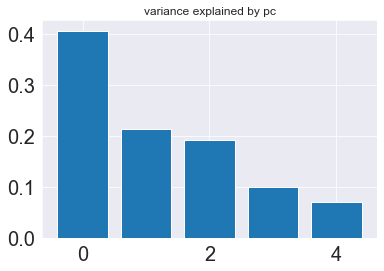

In [64]:
# plot the variance explained by pcs
plt.bar(range(PCS_n),sklearn_pca.explained_variance_ratio_)
plt.title('variance explained by pc')
plt.show()

In [65]:
# check the explained variance reatio
print(sklearn_pca.explained_variance_ratio_)
# get the Principal components
pcs =sklearn_pca.components_




stds = stocks_ret.std()

[0.40590772 0.21422394 0.19207896 0.09983014 0.07047255]


In [66]:
pcs[1]

array([ 0.65666666,  0.58144576, -0.22150994, -0.05619169,  0.38194476,
       -0.18056512])

In [67]:
port1 =pcs[1] / np.sum(pcs[1]) # Normalize to sum to 1
port2 =pcs[2] / np.sum(pcs[2]) # Normalize to sum to 1
port3 =pcs[3] / np.sum(pcs[3]) # Normalize to sum to 1

In [68]:
opt_df = pd.DataFrame(columns =stocks_ret.columns )
data = stocks_ret+1
for obj in ['Sharpe', 'Kelly', 'Max Div', "min var", 'erc']:
    #print('Optimazation Method:', obj)
    result = Optimize_Portfolio(data, objective=obj)
    #print(result['x'].round(2), "\n")
    opt_df.loc[obj,:] = result['x'].round(2)

#print("Optimazation Method: Risk Parity")
#print(risk_parity(data))

opt_df.loc['Risk Parity',:] = risk_parity(data)

## Add CDAR portfolio
opt_df.loc['CDAR Parity',:] =cdar_parity(stocks_ret)


### Add PCA N=3 portfolio

In [69]:
opt_df

,GLD,TLT,VTI,BTC-USD,DBMF,XACT-SMABOLAG.ST
Sharpe,0.14,0.0,0.07,0.05,0.63,0.1
Kelly,-0.0,0.0,-0.0,0.96,0.04,0.0
Max Div,0.08,0.3,0.12,0.02,0.38,0.08
min var,0.07,0.29,0.17,-0.0,0.45,0.02
erc,0.16,0.24,0.13,0.04,0.31,0.12
Risk Parity,0.19,0.2,0.15,0.04,0.29,0.13
CDAR Parity,0.18,0.08,0.12,0.05,0.47,0.1


In [60]:
port_rets_df = (stocks_ret+1).cumprod()
strategy_evaluation(port_rets_df, port_rets_df.columns, freq = 'M')

,CAGR,Volatility,Sharpe,Sortino,Max DD,MAR
GLD,8.3%,14.8%,0.6,1.0,-14.0%,0.60
TLT,-2.6%,14.6%,-0.2,-0.3,-30.0%,0.09
VTI,10.9%,18.9%,0.6,0.7,-21.0%,0.52
BTC-USD,32.3%,72.8%,0.4,0.8,-54.0%,0.60
DBMF,14.8%,10.3%,1.4,3.7,-5.0%,2.95
XACT-SMABOLAG.ST,12.6%,22.5%,0.6,0.7,-23.0%,0.55


In [61]:
correlation_map(port_rets_df)

,GLD,TLT,VTI,BTC-USD,DBMF,XACT-SMABOLAG.ST
GLD,1.00,0.33,0.22,0.12,0.29,0.22
TLT,0.33,1.00,-0.05,0.02,-0.16,0.04
VTI,0.22,-0.05,1.00,0.56,-0.04,0.88
BTC-USD,0.12,0.02,0.56,1.00,0.10,0.46
DBMF,0.29,-0.16,-0.04,0.10,1.00,-0.03
XACT-SMABOLAG.ST,0.22,0.04,0.88,0.46,-0.03,1.00


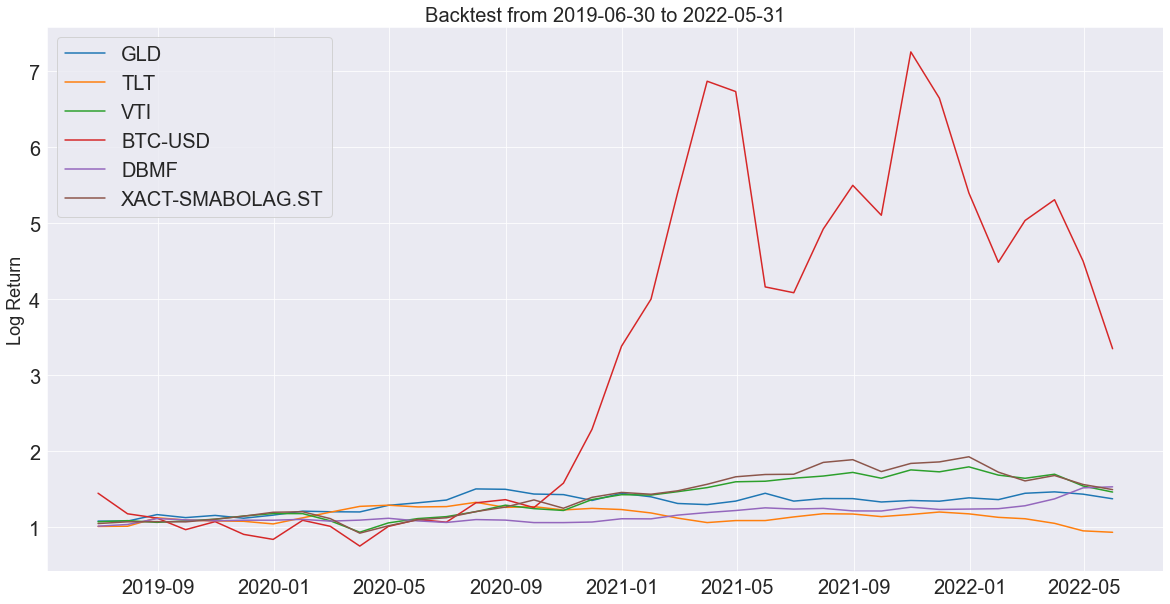

In [62]:
sns.set_style("darkgrid");
plt.figure(figsize=(20,10));
for i in port_rets_df.columns:
    plt.plot(port_rets_df[i], label = i);


start = datetime.date(port_rets_df.index.min());    
end = datetime.date(port_rets_df.index.max());
#plt.yscale("log")
plt.ylabel('Log Return', fontsize=18)
plt.legend(loc=2, prop={'size': 20});
plt.title('Backtest from ' + str(start) + ' to ' + str(end), fontsize=20)
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)